In [1]:
import numpy as np
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt 
from models.gru import GRU
from losses.correlation_loss import CorrelationLoss
from losses.hybrid_loss import HybridLoss
from models.attention_gru import AttentionGRU

In [2]:
# train_path = "../datasets/btc-2024-11-24.csv"
# test_path = "../datasets/btc-2024-11-25.csv"
train_path = "/pool/btcavax/binance-usdtfutures/depth-25/btc/2024-11-24.csv"
test_path = "/pool/btcavax/binance-usdtfutures/depth-25/btc/2024-11-25.csv"

train_df = pd.read_csv(train_path, sep="|")
test_df = pd.read_csv(test_path, sep="|")

In [3]:
for dataset in [train_df, test_df]:
    dataset["datetime"] = pd.to_datetime(dataset["time"], unit="us")
    dataset.set_index("datetime", inplace=True)

    dataset["ofi"] = (dataset["bid_0_price"].diff() > 0) * dataset["bid_0_size"] \
        - (dataset["bid_0_price"].diff() < 0) * dataset["bid_0_size"].shift(1) \
        + (dataset["ask_0_price"].diff() < 0) * dataset["ask_0_size"] \
        - (dataset["ask_0_price"].diff() > 0) * dataset["ask_0_size"].shift(1)

agg_dict = {key: "last" for key in train_df.columns}
agg_dict["ofi"] = "sum"

train_df = train_df.resample("1s").agg(agg_dict).ffill() # there are some seconds where no updates occur
test_df = test_df.resample("1s").agg(agg_dict).ffill()

In [4]:
import itertools
for dataset in [train_df, test_df]:
    dataset["midprice"] = (dataset["bid_0_price"] + dataset["ask_0_price"]) / 2
    dataset["bid_volume"] = dataset[[f"bid_{i}_size" for i in range(25)]].sum(axis=1)
    dataset["ask_volume"] = dataset[[f"ask_{i}_size" for i in range(25)]].sum(axis=1)
    dataset["total_volume"] = dataset["bid_volume"] + dataset["ask_volume"]
    dataset["spread"] = (dataset["ask_0_price"] - dataset["bid_0_price"]) / dataset["ask_0_price"]
    dataset["log_return"] = np.log(dataset["midprice"]) - np.log(dataset["midprice"].shift(1))
    dataset["ob_imb"] = (dataset["bid_volume"] - dataset["ask_volume"]) / (dataset["total_volume"])
    dataset["vwap"] = (dataset["midprice"] * dataset["total_volume"]).cumsum() / dataset["total_volume"].cumsum()

    dataset["target_log_return"] = dataset["log_return"].shift(-1)
    
lagged_features = ["log_return", "vwap", "spread", "midprice"]
lagged_col_names = []

for (dataset, lag, feature) in itertools.product([train_df, test_df], [1, 10, 60], lagged_features):
    dataset[f"{feature}_lag_{lag}"] = dataset[feature].shift(lag)
    lagged_col_names.append(f"{feature}_lag_{lag}")

for dataset in [train_df, test_df]:
    dataset.dropna(inplace=True)

In [6]:
train_df[["midprice", "bid_volume", "ask_volume", "total_volume", "spread", "log_return", "target_log_return", "ob_imb"]].describe()

,midprice,bid_volume,ask_volume,total_volume,spread,log_return,target_log_return,ob_imb
count,86338.000000,8.633800e+04,8.633800e+04,8.633800e+04,86338.000000,8.633800e+04,8.633800e+04,86338.000000
mean,97499.310712,1.124724e+06,9.418655e+05,2.066589e+06,0.000001,2.946622e-08,2.946622e-08,0.003652
std,796.821007,2.174276e+06,8.792170e+05,2.340529e+06,0.000003,5.869835e-05,5.869835e-05,0.511912
min,95829.850000,8.719118e+03,9.585293e+03,2.522825e+05,0.000001,-2.164931e-03,-2.164931e-03,-0.996564
25%,96788.450000,4.490780e+05,4.583636e+05,1.294632e+06,0.000001,0.000000e+00,0.000000e+00,-0.409991
50%,97740.050000,7.464467e+05,7.596018e+05,1.605127e+06,0.000001,0.000000e+00,0.000000e+00,-0.001130
75%,98225.650000,1.161271e+06,1.156477e+06,2.061257e+06,0.000001,0.000000e+00,0.000000e+00,0.421499
max,98617.950000,1.001985e+08,1.941460e+07,1.002864e+08,0.000342,2.406803e-03,2.406803e-03,0.998246


In [7]:
feature_cols = ["midprice", "bid_volume", "ask_volume", "total_volume", "spread", "log_return", "ob_imb", "vwap"] \
    + [f"bid_{i}_size" for i in range(2)] \
    + [f"bid_{i}_price" for i in range(2)] \
    + [f"ask_{i}_size" for i in range(2)] \
    + [f"ask_{i}_price" for i in range(2)] \
    + lagged_col_names

target_cols = ["target_log_return"]

In [9]:
class BtcDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

In [10]:
# Create sequences for AttentionGRU
def create_sequences(features, targets, seq_length=5):
    X, y = [], []
    for i in range(len(features) - seq_length):
        X.append(features[i:i + seq_length])
        y.append(targets[i + seq_length])
    return torch.stack(X), torch.stack(y)

In [ ]:
PARAMS = {
    "sequence_length": 20,
    "hidden_dim": 64,
    "epochs": 100,
    "batch_size": 32,
    "lr": 0.001,
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
train_features_df = train_df[feature_cols]
train_targets_df = train_df[target_cols]

test_features_df = test_df[feature_cols]
test_targets_df = test_df[target_cols]

train_features = torch.tensor(train_features_df.values, dtype=torch.float32).to(device)
train_targets = torch.tensor(train_targets_df.values, dtype=torch.float32).to(device)
test_features = torch.tensor(test_features_df.values, dtype=torch.float32).to(device)
test_targets = torch.tensor(test_targets_df.values, dtype=torch.float32).to(device)

train_features, train_targets = create_sequences(train_features, train_targets, PARAMS["sequence_length"])
test_features, test_targets = create_sequences(test_features, test_targets, PARAMS["sequence_length"])

In [17]:
train_dataset = BtcDataset(train_features, train_targets)
test_dataset = BtcDataset(test_features, test_targets)

train_loader = DataLoader(train_dataset, batch_size=PARAMS["batch_size"], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=PARAMS["batch_size"], shuffle=False)

In [36]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Forward pass through GRU layer
        gru_out, _ = self.gru(x)
        # Take the output from the last timestep
        output = self.fc(gru_out[:, -1, :])
        return output

In [ ]:
gru_model = GRU(input_size=len(feature_cols), hidden_size=PARAMS["hidden_dim"], output_size=len(target_cols), num_layers=1).to(device)
criterion = HybridLoss()
optimizer = torch.optim.Adam(gru_model.parameters(), lr=PARAMS["lr"])

for epoch in range(PARAMS["epochs"]):
    gru_model.train()  # Set the gru_model to training mode
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.float(), targets.float()

        optimizer.zero_grad()

        outputs = gru_model(inputs)

        loss = criterion(outputs, targets)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{PARAMS["epochs"]}, Training Loss: {avg_train_loss:.4f}")

Epoch 1/100, Training Loss: 0.4642
Epoch 2/100, Training Loss: 0.4615
Epoch 3/100, Training Loss: 0.4727
Epoch 4/100, Training Loss: 0.4720
Epoch 5/100, Training Loss: 0.4720
Epoch 6/100, Training Loss: 0.4715
Epoch 7/100, Training Loss: 0.4721
Epoch 8/100, Training Loss: 0.4722
Epoch 9/100, Training Loss: 0.4717
Epoch 10/100, Training Loss: 0.4717
Epoch 11/100, Training Loss: 0.4715
Epoch 12/100, Training Loss: 0.4722
Epoch 13/100, Training Loss: 0.4718
Epoch 14/100, Training Loss: 0.4718
Epoch 15/100, Training Loss: 0.4722
Epoch 16/100, Training Loss: 0.4716
Epoch 17/100, Training Loss: 0.4728
Epoch 18/100, Training Loss: 0.4713
Epoch 19/100, Training Loss: 0.4715
Epoch 20/100, Training Loss: 0.4713
Epoch 21/100, Training Loss: 0.4721
Epoch 22/100, Training Loss: 0.4717
Epoch 23/100, Training Loss: 0.4716
Epoch 24/100, Training Loss: 0.4716
Epoch 25/100, Training Loss: 0.4716
Epoch 26/100, Training Loss: 0.4717
Epoch 27/100, Training Loss: 0.4716
Epoch 28/100, Training Loss: 0.4716
E

In [ ]:
attention_gru = AttentionGRU(len(feature_cols), PARAMS["hidden_dim"], len(feature_cols), len(target_cols), device).to(device)
criterion = HybridLoss()
optimizer = torch.optim.Adam(attention_gru.parameters(), lr=PARAMS["lr"])

for epoch in range(PARAMS["epochs"]):
    attention_gru.train()
    epoch_loss = 0

    for batch_features, batch_targets in train_loader:
        optimizer.zero_grad()
        outputs, _ = attention_gru(batch_features, batch_features)
        loss = criterion(outputs[:, -1, :], batch_targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(attention_gru.parameters(), max_norm=1.0)

        optimizer.step()
        epoch_loss += loss.item()
    print(f"epoch: {epoch+1}, loss: {epoch_loss/len(train_loader)}")

epoch: 1, loss: 1289.8829645961523
epoch: 2, loss: 1289.0254410356283
epoch: 3, loss: 1311.0008391588926
epoch: 4, loss: 1334.5815757289529
epoch: 5, loss: 1333.796370357275
epoch: 6, loss: 1334.215469904244
epoch: 7, loss: 1333.0544686168432
epoch: 8, loss: 1333.991588704288
epoch: 9, loss: 1333.8118888959289
epoch: 10, loss: 1333.7460384517908
epoch: 11, loss: 1332.7207901775837
epoch: 12, loss: 1334.0635074079037
epoch: 13, loss: 1333.7737456560135
epoch: 14, loss: 1334.707877650857
epoch: 15, loss: 1333.8209464401007
epoch: 16, loss: 1333.5739616975188
epoch: 17, loss: 1333.6175707131624
epoch: 18, loss: 1333.5123227238655
epoch: 19, loss: 1334.5800734981894
epoch: 20, loss: 1334.1452100351453
epoch: 21, loss: 1333.5638540312648
epoch: 22, loss: 1333.727689690888
epoch: 23, loss: 1334.295938372612
epoch: 24, loss: 1333.3907540291548
epoch: 25, loss: 1334.2962095811963
epoch: 26, loss: 1333.8824764341116
epoch: 27, loss: 1334.1145413219929
epoch: 28, loss: 1333.9214280694723
epoch: 

In [54]:
def evaluate_model(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch_features, batch_targets in test_loader:
            # Move data to device
            batch_features = batch_features.to(device)
            batch_targets = batch_targets.to(device)
            
            # Get model predictions
            predictions = model(batch_features)
            
            # Take the last time step predictions
            # predictions = predictions[:, -1, :]
            
            # Collect predictions and targets
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(batch_targets.cpu().numpy())
    
    # Concatenate all predictions and targets
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    return all_predictions, all_targets

def plot_results(y_true, y_pred, feature_name, feature_index):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true[:, feature_index], label="Actual", linestyle='', marker='o')
    plt.plot(y_pred[:, feature_index], label="Predicted", linestyle='', marker='x')
    plt.title(f"Actual vs Predicted {feature_name}", fontsize=16)
    plt.xlabel("Timestep", fontsize=14)
    plt.ylabel(feature_name, fontsize=14)
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.show()

In [ ]:
# Evaluate the model
predictions, targets = evaluate_model(gru_model, test_loader, device)

In [56]:
residuals = targets - predictions

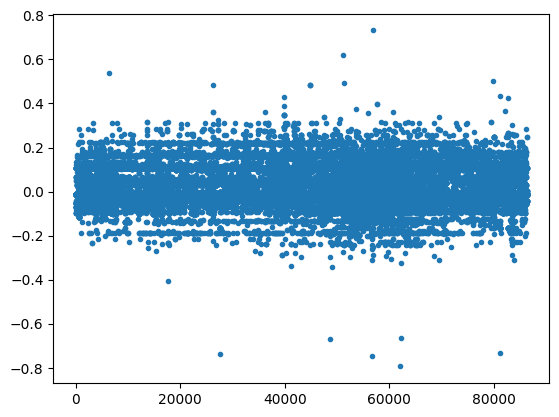

In [57]:
plt.plot(residuals, linestyle='', marker='.')

In [58]:
residuals.std()

np.float32(0.06743555)

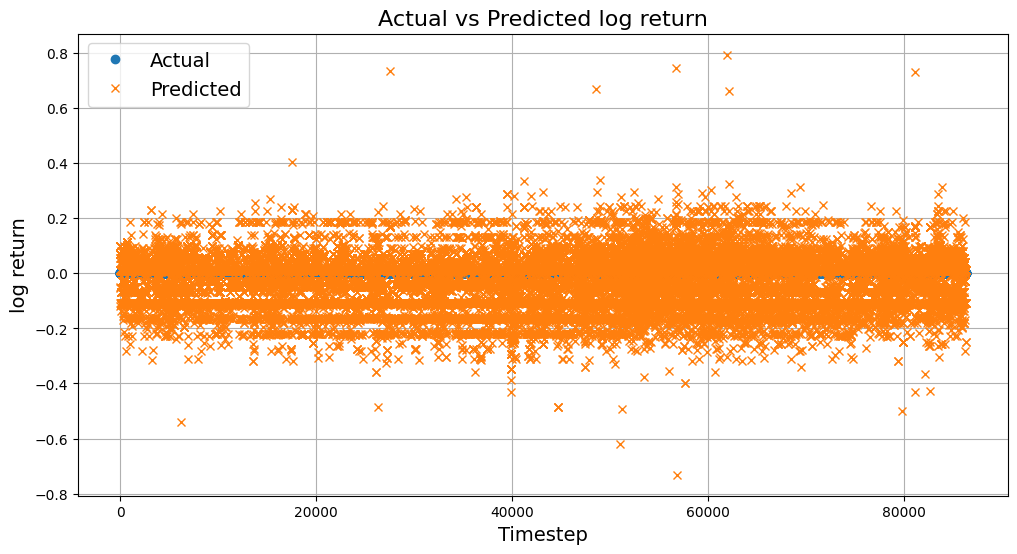

In [59]:
plot_results(targets, predictions, "log return", 0)